# Resting-State fMRI Analysis in R
### From Preprocessed Data to Functional Connectivity

#### 
**Authors**: 
Giulia Baracchini & Monika Doerig

**Date**: 13 Jan 2026

### Citation and Resources:

#### Tools included in this workflow
__R__:
- R Core Team. (2025). R: A language and environment for statistical computing (Version 4.4.3) [Software]. R Foundation for Statistical Computing. [https://www.R-project.org/](https://www.R-project.org/)

#### Workflows this work is based on
Original work from Giulia Baracchini: 
- [Resting-state fMRI: From raw data to analyses](https://github.com/giuliabaracc/teaching_fMRI/blob/main/fMRI_restpreprocnet.html)
- [teaching_fMRI](https://github.com/giuliabaracc/teaching_fMRI/blob/main/code/Tutorial_fMRI_complete.R)


#### Dataset
__HCP__
- [3T young adults resting-state dataset](https://www.humanconnectome.org/study/hcp-young-adult/data-releases)

__Schefer parcellation__
- [ThomasYeoLab](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal)

## Introduction

This notebook is adapted from Giulia Baracchini's comprehensive fMRI preprocessing tutorial ([available on GitHub](https://github.com/giuliabaracc/teaching_fMRI/blob/main/fMRI_restpreprocnet.html)), which covers the essential steps of resting-state fMRI analysis from raw data preprocessing through functional connectivity analyses.

The original tutorial provides a complete pipeline covering:

1. **Standard fMRI preprocessing** - preparing raw neuroimaging data for analysis
2. **Resting-state fMRI denoising** - removing artifacts and noise from the signal
3. **Time-series extraction and parcellation** - converting voxel-level data to meaningful brain regions
4. **Functional connectivity analyses** - examining statistical relationships between brain regions

## What This Notebook Covers

While the original tutorial works with multiple subjects and uses the Schaefer 200 region-7 network parcellation, this notebook focuses on a single-subject analysis using the **Schaefer 200 region-17 network** parcellation applied to subject 101309. 

### Key Concepts

**Parcellation**: The process of grouping individual voxels into meaningful brain regions or "parcels." Instead of analyzing thousands of individual voxels, we average signals within anatomically or functionally defined regions, making our analyses more interpretable and computationally manageable.

**Functional Connectivity (FC)**: A statistical measure (typically Pearson's correlation) that quantifies how synchronously different brain regions activate during rest. The result is a region × region matrix where each entry represents the strength of correlation between two brain areas.

### Analysis Pipeline

This notebook focuses on the **analysis phase** using already preprocessed and parcellated data. Starting with clean time series data from 200 brain regions, we implement:

1. **Data normalization** - standardizing time series signals across regions
2. **Functional connectivity calculation** - computing correlation matrices between brain regions  
3. **Fisher z-transformation** - normalizing correlation values for statistical analysis
4. **Network visualization** - creating heatmaps and brain plots to visualize connectivity patterns
5. **Nodal strength analysis** - quantifying each region's overall connectivity
6. **Relationships to other measures of brain organisation** - relating connectivity patterns to brain organization gradients and gene expression patterns

The Schaefer parcellation we're using divides the brain into 200 regions across 17 functional networks, providing a good balance between spatial resolution and interpretability for resting-state connectivity analyses.

## Running R in Jupyter with Python Kernel

<div style="background-color: light-dark(#fff3cd, #4a3800); border-left: 4px solid #ff9800; padding: 15px; margin: 20px 0; color: light-dark(#856404, #ffd966);">
    <p style="color: light-dark(#856404, #ffd966);">⚠️ <strong>Run R in Jupyter Notebook:</strong> This notebook uses <strong>R magic commands</strong> (<code style="background-color: light-dark(#ffe69c, #332600); color: light-dark(#856404, #ffd966); padding: 2px 6px; border-radius: 3px;">%%R</code>) to run R code within a Python kernel environment. This approach offers several advantages:</p>
    <ul style="color: light-dark(#856404, #ffd966);">
        <li><strong>No kernel switching required</strong> - all code runs in the Python kernel</li>
        <li><strong>Seamless Python ↔ R integration</strong> - easy data exchange between languages</li>
        <li><strong>Fully automated setup</strong> - no manual kernel installation needed</li>
    </ul>
    <p style="color: light-dark(#856404, #ffd966);"><em>Note: Alternatively, Jupyter supports native R kernels, but the magic command approach keeps everything within the Python kernel for simpler workflow management.</em></p>
</div>

### Setup Steps
**1. Install R runtime and packages via mamba:**

In [1]:
# r-essentials: R runtime, rpy2: Python↔R bridge
!mamba install -c conda-forge r-essentials rpy2 r-sf r-units r-s2 mamba>=2.1 conda>=24.11 libsqlite>=3.35 -y --verbose

info     libmamba Searching index cache file for repo 'conda-forge/linux-64'
info     libmamba Valid cache found  for 'conda-forge/linux-64': 1
info     libmamba Searching index cache file for repo 'conda-forge/noarch'
info     libmamba Valid cache found  for 'conda-forge/noarch': 1
info     libmamba Checking for CA certificates at the root prefix: "/opt/conda/ssl/cacert.pem"
info     libmamba Using CA certificates from `conda-forge::ca-certificates` installed in the root prefix (i.e "/opt/conda/ssl/cacert.pem")
info     libmamba Attempting to read libsolv solv file "/opt/conda/pkgs/cache/88ec62ec.solv" for repo https://conda.anaconda.org/conda-forge/linux-64
info     libmamba Expecting solv metadata : {"etag":"\"6f821fd70f5e4c4539ad9c47906c4bfd\"","mod":"Thu, 22 Jan 2026 13:16:59 GMT","tool_version":"2.0_0.7.35","url":"https://conda.anaconda.org/conda-forge/linux-64"}
info     libmamba Loaded solv metadata : {"etag":"\"6f821fd70f5e4c4539ad9c47906c4bfd\"","mod":"Thu, 22 Jan 2026 13:16:

**2. Enable `%%R` magic commands:**

We only need to run it once for the first time. After these installations, the Jupyter Notebook now supports both Python 3 and R programming languages.

In [2]:
%load_ext rpy2.ipython

**3. Install R packages from CRAN and GitHub:**

In [7]:
%%R
# ==============================================================================
#  Setup a User-Specific R Library and Install Packages
# ==============================================================================
# This code creates a personal library in the user's home directory and tells
# R to use it for all package installations. This ensures our environment is
# isolated, reproducible, and avoids permission errors.

# 1. Define and create a personal library path
user_lib <- "~/R/library"
dir.create(user_lib, recursive = TRUE, showWarnings = FALSE)

# 2. Add the personal library to the front of R's library search path
.libPaths(c(user_lib, .libPaths()))

# 3. Set a default CRAN mirror
options(repos = c(CRAN = "https://cloud.r-project.org" ))

# 4. Install required packages from CRAN into the personal library
#    We check if they are already installed to avoid re-installing every time.
install.packages(c("remotes", "ggplot2", "dplyr", "tidyr",
                   "devtools", "superheat"))

# 5. Install required packages from GitHub
#    Using `force = TRUE` can help ensure the latest version is installed if needed.
remotes::install_github("ggseg/ggseg", upgrade = "never", force = TRUE)
remotes::install_github("ggseg/ggsegSchaefer", upgrade = "never", force = TRUE)

# 6. Verify the library path
print("R packages will be installed in and loaded from:")
print(.libPaths())

* installing *source* package ‘checkmate’ ...
** this is package ‘checkmate’ version ‘2.3.3’
** package ‘checkmate’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.2.0-16) 15.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c all_missing.c -o all_missing.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/cond

installing to /home/jovyan/R/library/00LOCK-checkmate/00new/checkmate/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (checkmate)
* installing *source* package ‘rex’ ...
** this is package ‘rex’ version ‘1.2.1’
** package ‘rex’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c C_FORTRAN_interface.c -o C_FORTRAN_interface.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifac

installing to /home/jovyan/R/library/00LOCK-mvtnorm/00new/mvtnorm/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (mvtnorm)
* installing *source* package ‘TH.data’ ...
** this is package ‘TH.data’ version ‘1.1-5’
** package ‘TH.data’ successfully unpacked and MD5 sums checked
** using staged installation
** data
*** moving datasets to lazyload DB
** demo
** inst
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing i

x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c bckslv.f -o bckslv.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c chol.f -o chol.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda

installing to /home/jovyan/R/library/00LOCK-SparseM/00new/SparseM/libs
** R
** data
** demo
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘diag’ from package ‘base’ in package ‘SparseM’
Creating a generic function for ‘diag<-’ from package ‘base’ in package ‘SparseM’
Creating a generic function for ‘norm’ from package ‘base’ in package ‘SparseM’
Creating a generic function for ‘backsolve’ from package ‘base’ in package ‘SparseM’
Creating a generic function for ‘forwardsolve’ from package ‘base’ in package ‘SparseM’
Creating a generic function for ‘model.response’ from package ‘stats’ in package ‘SparseM’


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (SparseM)
* installing *source* package ‘MatrixModels’ ...
** this is package ‘MatrixModels’ version ‘0.5-4’
** package ‘MatrixModels’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (MatrixModels)
* installing *source* package ‘profmem’ ...
** this is pack

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I. -Ihunspell -DBUILDING_LIBHUNSPELL -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -I. -Ihunspell -DBUILDING_LIBHUNSPELL -I'/opt/conda/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibilit

installing to /home/jovyan/R/library/00LOCK-hunspell/00new/hunspell/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (hunspell)
* installing *source* package ‘git2r’ ...
** this is package ‘git2r’ version ‘0.36.2’
** package ‘git2r’ successfully unpacked and MD5 sums checked
** using staged installation


checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for pkg-config... /usr/bin/pkg-config
checking pkg-config is at least version 0.9.0... yes
checking whether the libgit2 version will work in git2r... no

  -----------------------------------------------------------------------

   Configuration failed to find 'libgit2 >= 1.0' and its
   dependencies libssh2 and openssl.

   Try installing:
     * brew: libgit2 (MacOS)
     * deb: libgit2-dev   (Debian, Ubuntu, etc)
     * rpm: libgit2-devel (Fedora, CentOS, RHEL)
   and try again.

   If the libgit2 library is installed on your system but the git2r
   configuration is unable to find it, you can specify the include and
   lib path to libgit2 with:

   given you downloaded a tar-gz archive:
   R CMD INSTALL git2r-.tar.gz --configure-vars='INCLUDE_DIR=/path/to/include LIB_DIR=/path/to/lib'

   or cloned the GitHub git2r repository into a directory:
   R CMD INSTALL git2r/ --configu

configure: error: in '/tmp/RtmpCtbBSb/R.INSTALL89fd50194681/git2r':
configure: error: package dependency requirements 'libgit2 >= 1.0', 'openssl', and 'libssh2' could not be satisfied.
See 'config.log' for more details
ERROR: configuration failed for package ‘git2r’
* removing ‘/home/jovyan/R/library/git2r’
* installing *source* package ‘mockery’ ...
** this is package ‘mockery’ version ‘0.4.5’
** package ‘mockery’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (mockery)
* installing *source* package ‘pingr’ ...
** this is package ‘pingr’ version ‘2.0.5’
** package ‘pingr’ successfully unpacke

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c dns.c -o dns.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -

installing to /home/jovyan/R/library/00LOCK-pingr/00new/pingr/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (pingr)
* installing *source* package ‘webfakes’ ...
** this is package ‘webfakes’ version ‘1.4.0’
** package ‘webfakes’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.2.0-16) 15.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_MBEDTLS -Imbedtls/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -DNO_CGI -DNO_FILES -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c civetweb.c -o civetweb.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -DUSE_MBEDTLS -Imbedtls/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -DNO_CGI -DNO_FILES -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=

x86_64-conda-linux-gnu-ar: creating libmbedtls.a
installing to /home/jovyan/R/library/00LOCK-webfakes/00new/webfakes/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (webfakes)
* installing *source* package ‘ggplot2movies’ ...
** this is package ‘ggplot2movies’ version ‘0.0.1’
** package ‘ggplot2movies’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c aitoff.c -o aitoff.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4

installing to /home/jovyan/R/library/00LOCK-mapproj/00new/mapproj/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (mapproj)
* installing *source* package ‘quarto’ ...
** this is package ‘quarto’ version ‘1.5.1’
** package ‘quarto’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if instal

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -I'/opt/conda/lib/R/library/systemfonts/include' -I'/opt/conda/lib/R/library/textshaping/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c SvgStream.cpp -o SvgStream.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -I'/opt/conda/lib/R/library/systemfonts/include' -I'/opt/conda/lib/R/library/textshaping/include' -DNDEBUG -D_FORTIFY_SOURC

installing to /home/jovyan/R/library/00LOCK-svglite/00new/svglite/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (svglite)
* installing *source* package ‘vdiffr’ ...
** this is package ‘vdiffr’ version ‘1.0.8’
** package ‘vdiffr’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (conda-forge gcc 15.2.0-16) 15.2.0’
using C++11


x86_64-conda-linux-gnu-c++ -std=gnu++11 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c compare.cpp -o compare.o
x86_64-conda-linux-gnu-c++ -std=gnu++11 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -f

installing to /home/jovyan/R/library/00LOCK-vdiffr/00new/vdiffr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (vdiffr)
* installing *source* package ‘microbenchmark’ ...
** this is package ‘microbenchmark’ version ‘1.5.0’
** package ‘microbenchmark’ successfully unpacked and MD5 sums checked
** using staged installation


checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to enable C11 features... none needed
checking for stdio.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for inttypes.h... yes
checking for stdint.h... yes
checking for strings.h... yes
checking for sys/stat.h... yes
checking for sys/types.h... yes
checking for unistd.h... yes
checking for stdint.h... (cached) yes
checking for stdlib.h... (cached) yes
checking for sys/time.h... yes
checking for uint64_t... yes
checking for error_at_line... yes
checking for mach_absolute_time... no
checking for library containing clock_gettime... non

** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.2.0-16) 15.2.0’


x86_64-conda-linux-gnu-cc -shared -L/opt/conda/lib/R/lib -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib -o microbenchmark.so do_nothing.o init.o nanotimer.o -L/opt/conda/lib/R/lib -lR


installing to /home/jovyan/R/library/00LOCK-microbenchmark/00new/microbenchmark/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (microbenchmark)
* installing *source* package ‘nycflights13’ ...
** this is package ‘nycflights13’ version ‘1.0.2’
** package ‘nycflights13’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded fr

Using PKG_CFLAGS=
Using PKG_LIBS=-lmysqlclient
-----------------------------[ ANTICONF ]-----------------------------
Configure could not find suitable mysql/mariadb client library. Try installing:
 * deb: libmariadbclient-dev | libmariadb-client-lgpl-dev (Debian, Ubuntu)
 * rpm: mariadb-connector-c-devel | mariadb-devel | mysql-devel (Fedora, CentOS, RHEL)
 * csw: mysql56_dev (Solaris)
 * brew: mariadb-connector-c (OSX)
If you already have a mysql client library installed, verify that either
mariadb_config or mysql_config is on your PATH. If these are unavailable
you can also set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
--------------------------[ ERROR MESSAGE ]----------------------------
<stdin>:1:10: fatal error: mysql.h: No such file or directory
compilation terminated.
-----------------------------------------------------------------------


ERROR: configuration failed for package ‘RMySQL’
* removing ‘/home/jovyan/R/library/RMySQL’
* installing *source* package ‘RPostgreSQL’ ...
** this is package ‘RPostgreSQL’ version ‘0.7-8’
** package ‘RPostgreSQL’ successfully unpacked and MD5 sums checked
** using staged installation


checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking target system type... x86_64-pc-linux-gnu
checking for pg_config... no
configure: checking for PostgreSQL header files
configure: Checking include /usr/include.
configure: Checking include /usr/include/postgresql.
configure: Checking include /usr/local/include.
configure: Checking include /usr/local/include/postgresql.
configure: Checking include /usr/local/pgsql/include.
configure: Checking include /usr/local/postgresql/include.
configure: Checking lib /usr/lib.
configure: Checking lib /usr/lib/postgresql.
configure: Checking lib /usr/local/lib.
configure: Checking lib /usr/local/lib/postgresql.
configure: Checking lib /usr/local/postgresql/lib.
x86_64-conda-linux-gnu-cc -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-bas

conftest.c:1:10: fatal error: libpq-fe.h: No such file or directory
    1 | #include <libpq-fe.h>
      |          ^~~~~~~~~~~~
compilation terminated.
./configure: line 1999: ./pqconftest: No such file or directory
** libs


config.status: creating src/Makevars
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RS-DBI.c -o RS-DBI.o


using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.2.0-16) 15.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG -I  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c RS-PQescape.c -o RS-PQescape.o


In file included from RS-PQescape.c:7:
RS-PostgreSQL.h:23:14: fatal error: libpq-fe.h: No such file or directory
   23 | #    include "libpq-fe.h"
      |              ^~~~~~~~~~~~
compilation terminated.
make: *** [/opt/conda/lib/R/etc/Makeconf:204: RS-PQescape.o] Error 1
ERROR: compilation failed for package ‘RPostgreSQL’
* removing ‘/home/jovyan/R/library/RPostgreSQL’
* installing *source* package ‘repurrrsive’ ...
** this is package ‘repurrrsive’ version ‘1.1.0’
** package ‘repurrrsive’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (repurrrsive)
* installing *source* pa

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c chop.cpp -o chop.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include 

installing to /home/jovyan/R/library/00LOCK-dplyr/00new/dplyr/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (dplyr)
* installing *source* package ‘htmlTable’ ...
** this is package ‘htmlTable’ version ‘2.4.3’
** package ‘htmlTable’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c reassign.c -o reassign.o
x86_64-conda-linux-gnu-cc -shared -L/opt/conda/lib/R/lib -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib -o covr.so reassign.o -L/opt/conda/lib/R/lib -lR


** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (covr)
* installing *source* package ‘multcomp’ ...
** this is package ‘multcomp’ version ‘1.4-29’
** package ‘multcomp’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installati

x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c akj.f -o akj.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c boot.f -o boot.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feeds

installing to /home/jovyan/R/library/00LOCK-quantreg/00new/quantreg/libs
** R
** data
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (quantreg)
* installing *source* package ‘bench’ ...
** this is package ‘bench’ version ‘1.1.4’
** package ‘bench’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 15.2.0-16) 15.2.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c load.c -o load.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2

installing to /home/jovyan/R/library/00LOCK-bench/00new/bench/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (bench)
* installing *source* package ‘Lahman’ ...
** this is package ‘Lahman’ version ‘13.0-0’
** package ‘Lahman’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing i

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -Ivendor -DRSQLITE_USE_BUNDLED_SQLITE -DSQLITE_ENABLE_RTREE -DSQLITE_ENABLE_FTS3 -DSQLITE_ENABLE_FTS3_PARENTHESIS -DSQLITE_ENABLE_FTS5 -DSQLITE_ENABLE_JSON1 -DSQLITE_ENABLE_STAT4 -DSQLITE_SOUNDEX -DSQLITE_USE_URI=1 -DSQLITE_MAX_LENGTH=2147483647 -DHAVE_USLEEP=1 -I'/home/jovyan/R/library/plogr/include' -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c DbColumn.cpp -o DbColumn.o
x86_64-conda-linux-gnu-c

In file included from vendor/boost/smart_ptr/detail/sp_thread_sleep.hpp:22,
                 from vendor/boost/smart_ptr/detail/yield_k.hpp:23,
                 from vendor/boost/smart_ptr/detail/spinlock_gcc_atomic.hpp:14,
                 from vendor/boost/smart_ptr/detail/spinlock.hpp:42,
                 from vendor/boost/smart_ptr/detail/spinlock_pool.hpp:25,
                 from vendor/boost/smart_ptr/shared_ptr.hpp:29,
                 from vendor/boost/shared_ptr.hpp:17,
                 from DbColumn.h:9,
                 from DbDataFrame.cpp:3:
vendor/boost/config/pragma_message.hpp:24:34: note: '#pragma message: The practice of declaring the Bind placeholders (_1, _2, ...) in the global namespace is deprecated. Please use <boost/bind/bind.hpp> + using namespace boost::placeholders, or define BOOST_BIND_GLOBAL_PLACEHOLDERS to retain the current behavior.'
   24 | # define BOOST_PRAGMA_MESSAGE(x) _Pragma(BOOST_STRINGIZE(message(x)))
      |                                  ^~

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG -Ivendor -DRSQLITE_USE_BUNDLED_SQLITE -DSQLITE_ENABLE_RTREE -DSQLITE_ENABLE_FTS3 -DSQLITE_ENABLE_FTS3_PARENTHESIS -DSQLITE_ENABLE_FTS5 -DSQLITE_ENABLE_JSON1 -DSQLITE_ENABLE_STAT4 -DSQLITE_SOUNDEX -DSQLITE_USE_URI=1 -DSQLITE_MAX_LENGTH=2147483647 -DHAVE_USLEEP=1 -I'/home/jovyan/R/library/plogr/include' -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib   -fvisibility=hidden -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c DbResult.cpp -o DbResult.o
x86_64-conda-linux-gnu-c

installing to /home/jovyan/R/library/00LOCK-RSQLite/00new/RSQLite/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RSQLite)
* installing *source* package ‘lintr’ ...
** this is package ‘lintr’ version ‘3.3.0-1’
** package ‘lintr’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from fina

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix   -c cpp11.cpp -o cpp11.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/opt/conda/lib/R/include" -DNDEBUG  -I'/opt/conda/lib/R/library/cpp11/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstac

installing to /home/jovyan/R/library/00LOCK-tidyr/00new/tidyr/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (tidyr)
* installing *source* package ‘devtools’ ...
** this is package ‘devtools’ version ‘2.4.6’
** package ‘devtools’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary 

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c Hmisc.c -o Hmisc.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1763744870449/work=/usr/local/src/conda/r-base-4.5.2 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c  cidxcn.f90 -o cidxcn.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune

installing to /home/jovyan/R/library/00LOCK-Hmisc/00new/Hmisc/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Hmisc)


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpjJgncD/remotes71c125ed441d/ggseg-ggseg-7def8bd/DESCRIPTION’ ... OK
* preparing ‘ggseg’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggseg_1.6.8.9000.tar.gz’



* installing *source* package ‘ggseg’ ...
** this is package ‘ggseg’ version ‘1.6.8.9000’
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggseg)
* installing *source* package ‘ggseg3d’ ...
** this is package ‘ggseg3d’ version ‘1.6.3’
** package ‘ggseg3d’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing

── R CMD build ─────────────────────────────────────────────────────────────────


** testing if installed package keeps a record of temporary installation path
* DONE (ggseg3d)


* checking for file ‘/tmp/RtmpjJgncD/remotes71c1dd2b896/ggseg-ggsegSchaefer-91bb220/DESCRIPTION’ ... OK
* preparing ‘ggsegSchaefer’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsegSchaefer_2.0.4.tar.gz’



* installing *source* package ‘ggsegSchaefer’ ...
** this is package ‘ggsegSchaefer’ version ‘2.0.4’
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggsegSchaefer)


Installing packages into ‘/home/jovyan/R/library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘checkmate’, ‘rex’, ‘gridExtra’, ‘htmlTable’, ‘Formula’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘SparseM’, ‘MatrixModels’, ‘profmem’, ‘plogr’, ‘xmlparsedata’, ‘whoami’, ‘hunspell’, ‘covr’, ‘git2r’, ‘mockery’, ‘pingr’, ‘webfakes’, ‘ggplot2movies’, ‘Hmisc’, ‘mapproj’, ‘multcomp’, ‘quantreg’, ‘quarto’, ‘svglite’, ‘vdiffr’, ‘bench’, ‘Lahman’, ‘microbenchmark’, ‘nycflights13’, ‘RMySQL’, ‘RPostgreSQL’, ‘RSQLite’, ‘repurrrsive’, ‘BiocManager’, ‘DT’, ‘foghorn’, ‘gmailr’, ‘lintr’, ‘rhub’, ‘spelling’

trying URL 'https://cloud.r-project.org/src/contrib/checkmate_2.3.3.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/rex_1.2.1.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/gridExtra_2.3.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/htmlTable_2.4.3.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/Formula_1.2-5.tar.gz'
trying URL 'https://cloud.r-p

**4. All subsequent R code uses the `%%R` cell magic:**

Each cell containing R code must start with `%%R` to be executed as R code.

In [8]:
%%R
# Load packages to confirm
library(ggseg)
library(ggsegSchaefer)
library(sf)
library(units)
library(s2)
library(superheat)
library(ggplot2)
library(dplyr)
library(tidyr)

Linking to GEOS 3.14.1, GDAL 3.12.1, PROJ 9.7.1; sf_use_s2() is TRUE
udunits database from /opt/conda/lib/R/library/units/share/udunits/udunits2.xml

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Data download 

In [9]:
%%R
# Create data directory
dir.create("data", showWarnings = FALSE)

# Download files into data folder
download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/margulies2016_fcgradient01_20017Schaefer.csv", 
              destfile = "data/margulies2016_fcgradient01_20017Schaefer.csv")

download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/gene_pc1_20017Schaefer.csv",
              destfile = "data/gene_pc1_20017Schaefer.csv")

# Don't forget the main data file too
download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/sub-101309_Schaefer20017.txt",
              destfile = "data/sub-101309_Schaefer20017.txt")

trying URL 'https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/margulies2016_fcgradient01_20017Schaefer.csv'
Content type 'text/plain; charset=utf-8' length 8044 bytes
downloaded 8044 bytes

trying URL 'https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/gene_pc1_20017Schaefer.csv'
Content type 'text/plain; charset=utf-8' length 8032 bytes
downloaded 8032 bytes

trying URL 'https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/sub-101309_Schaefer20017.txt'
Content type 'text/plain; charset=utf-8' length 3094605 bytes (3.0 MB)
downloaded 3.0 MB



### Load data and visualize data from one subject

In [10]:
%%R
###We are going to use data from subject 101309 in Scahefer 200-17 space
df <- read.table("./data/sub-101309_Schaefer20017.txt") 
atlas <- read.csv("./data/margulies2016_fcgradient01_20017Schaefer.csv")$region #our 200-17 regions important for plotting later

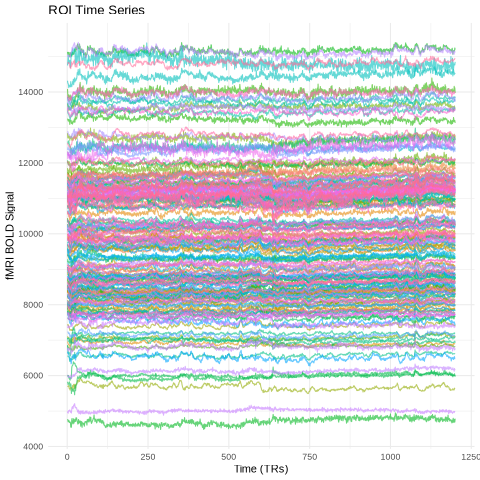

In [11]:
%%R
# Add a Time column so we can create a nice labelled plot
df2 <- df
df2$Time <- 1:nrow(df2)

# Reshape data frame to long format
df_long <- pivot_longer(df2, 
                        cols = -Time, 
                        names_to = "Region", 
                        values_to = "Signal")
# Plot
ggplot(df_long, aes(x = Time, y = Signal, color = Region)) +
  geom_line(alpha = 0.6) +
  theme_minimal() +
  labs(title = "ROI Time Series", x = "Time (TRs)", y = "fMRI BOLD Signal") +
  theme(legend.position = "none") 

### Normalize time series data

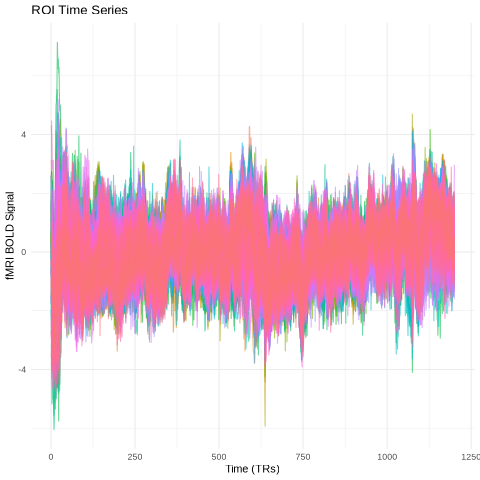

In [12]:
%%R
###First step: normalise their time series data
df_z <- scale(df, center = TRUE, scale = TRUE) 
df_z <- as.data.frame(df_z) #make data frame
  
#Plot df_z
# Add a Time column so we can create a nice labelled plot
df_z$Time <- 1:nrow(df_z)

#Reshape data frame to long format
df_z_long <- pivot_longer(df_z, 
                          cols = -Time, 
                          names_to = "Region", 
                          values_to = "Signal")
#Plot
ggplot(df_z_long, aes(x = Time, y = Signal, color = Region)) +
  geom_line(alpha = 0.6) +
  theme_minimal() +
  labs(title = "ROI Time Series", x = "Time (TRs)", y = "fMRI BOLD Signal") +
  theme(legend.position = "none")

### Calculate their Functional Connectivity (FC) matrix
Let’s do some analyses on these data now! First thing, let’s calculate functional connectivity (FC). As a refresher, FC is a statistical construct derived (typically) as the Pearson’s correlation between pairs of brain regions. The output is therefore a region x region matrix where each entry indicates how strong the correlation is between two regions. In our case, our FC matrix will be 200x200.

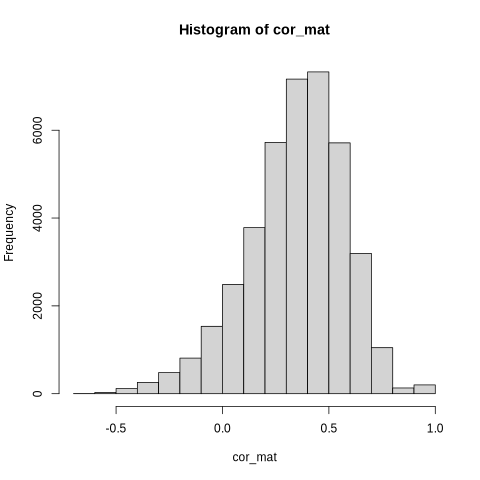

In [13]:
%%R
###Second step: calculate their FC matrix
matrix_df <- as.matrix(df) #convert to matrix format to do calculations

# Pearson's correlation
cor_mat <- cor(matrix_df) #compute FC on matrix format variable

#Look at distribution of FC values
hist(cor_mat) 

### Normalise FC values
For group analyses, we need to normalise these FC values: Fisher-z transformation

In [14]:
%%R
###Third step: normalise their FC values
z_mat <- atanh(cor_mat) 
# Clean matrix: replace Inf values that come from Fisher z-transform
z_mat[!is.finite(z_mat)] <- NA

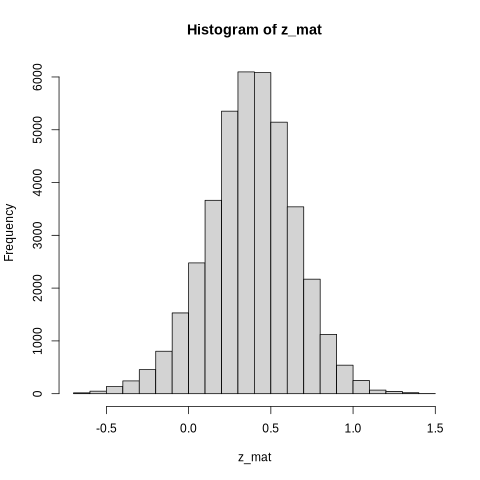

In [15]:
%%R
hist(z_mat)

### Visualise FC matrix
You can play with the value limits, but in generally you want to make sure you see boxes in your matrix reflecting the brain’s functional network organisation.

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the superheat package.
  Please report the issue to the authors.
This warning is displayed once per session.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


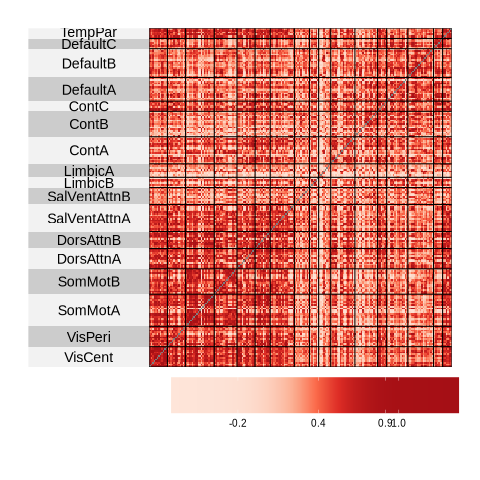

In [16]:
%%R
###Fourth step: roughly visualise their FC matrix

# Use these names to label your FC matrix
colnames(z_mat) <- atlas 
rownames(z_mat) <- atlas 

# Example: "17Networks_LH_VisCent_ExStr_1" → "VisCent"
networks <- sub("17Networks_.._([^_]+).*", "\\1", atlas)
networks <- factor(networks, levels = unique(networks))

reds <- colorRampPalette(c("#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"))(100)
superheat(z_mat,
          membership.rows = networks,
          membership.cols = networks,
          left.label.size = 0.4,
          bottom.label.size = 0,
          scale = FALSE,
          heat.pal = reds,
          # make the legend bigger
          legend.height = 0.25,
          legend.width = 2,
          legend.text.size = 10)

### Calculate Nodal strength
Let’s take this a step further. Let’s calculate how much each region is connected to the rest of the brain, a measure that is called node strength. [Node strength](https://sites.google.com/site/bctnet/list-of-measures), or region strength, is “the sum of weights of links connected to the node”. This will allow us to obtain a 1x200 vector that we can relate to a bunch of other measures of brain organisation.

In [17]:
%%R
###Fifth step: calculate nodal strength
node_strength <- rowSums(z_mat, na.rm = TRUE)

node_strength <- as.data.frame(node_strength)
rownames(node_strength) <- seq(1:200)

node_strength[,2] <- atlas

colnames(node_strength)[1] <- "Value"
colnames(node_strength)[2] <- "region"

merging atlas and data by 'region'


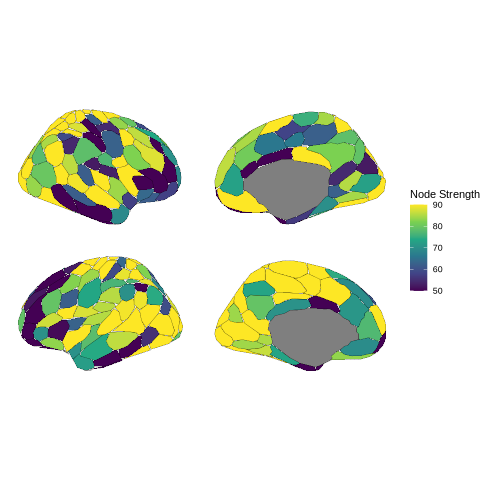

In [18]:
%%R
library(ggseg)
options(repr.plot.width = 12, repr.plot.height = 6)

# Use ggseg instead of ggplot + geom_brain
node_strength %>%
  ggseg(atlas = schaefer17_200,
        mapping = aes(fill = Value),
        position = "stacked",
        colour = "black", 
        size = 0.1) +
  scale_fill_viridis_c(limits = c(50, 90), oob = scales::squish) +
  theme_void() +
  labs(fill = "Node Strength")

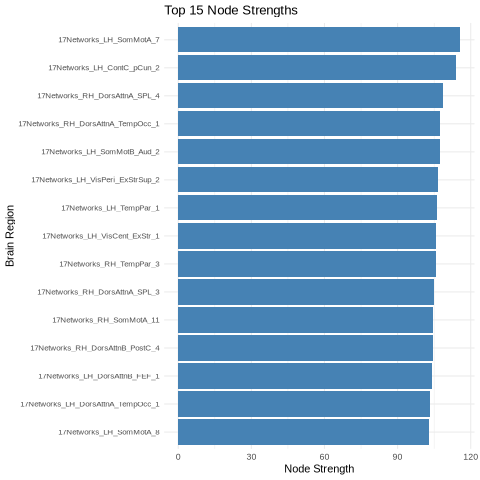

In [19]:
%%R
top_n <- 15  

node_strength %>%
  slice_max(Value, n = top_n) %>%
  ggplot(aes(x = reorder(region, Value), y = Value)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = paste("Top", top_n, "Node Strengths"),
       x = "Brain Region",
       y = "Node Strength") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))


### Relate their nodal strength measures to measures of brain organisation and gene organisation

In [20]:
%%R
###Sixth step: relate their nodal strength measures to measures of brain organisation and gene organisation
brain_organisation <- read.csv("./data/margulies2016_fcgradient01_20017Schaefer.csv")
gene_organisation <- read.csv("./data/gene_pc1_20017Schaefer.csv")

merging atlas and data by 'region'


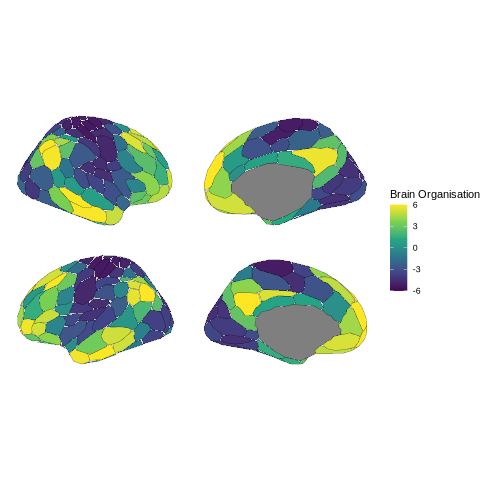

In [21]:
%%R
# Brain organisation
brain_organisation %>%
  ggseg(atlas = schaefer17_200,
        mapping = aes(fill = Value),
        position = "stacked",
        colour = "black", 
        size = 0.1) +
  scale_fill_viridis_c(limits = c(-6, 6), oob = scales::squish) +
  theme_void() +
  labs(fill = "Brain Organisation")

merging atlas and data by 'region'


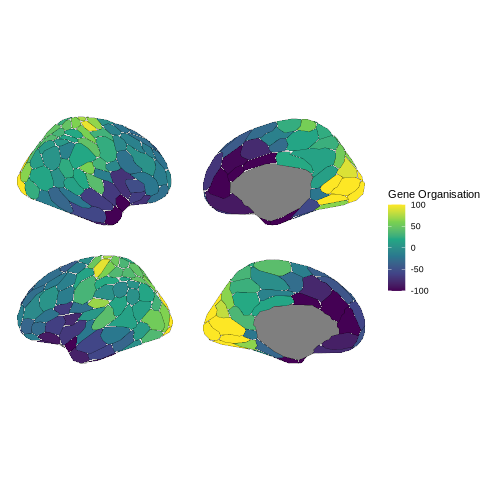

In [22]:
%%R
# Gene organisation
gene_organisation %>%
  ggseg(atlas = schaefer17_200,
        mapping = aes(fill = Value),
        position = "stacked",
        colour = "black", 
        size = 0.1) +
  scale_fill_viridis_c(limits = c(-100, 100), oob = scales::squish) +
  theme_void() +
  labs(fill = "Gene Organisation")

In [23]:
%%R
#Compute correlation amongst these vectors: nodal strength, brain organisation and gene organisation
corr_node_brainorg <- cor(node_strength$Value,brain_organisation$Value, method = 'spearman') 
corr_node_geneorg <- cor(node_strength$Value,gene_organisation$Value, method = 'spearman')

In [24]:
%%R
# Put results into a data frame
cor_results <- data.frame(
  Comparison = c("Nodal Strength vs Brain Organisation",
                 "Nodal Strength vs Gene Organisation"),
  Spearman_rho = c(corr_node_brainorg, corr_node_geneorg)
)

library(knitr)
kable(cor_results, digits = 3, caption = "Spearman correlations for Nodal Strength")



Table: Spearman correlations for Nodal Strength

|Comparison                           | Spearman_rho|
|:------------------------------------|------------:|
|Nodal Strength vs Brain Organisation |       -0.359|
|Nodal Strength vs Gene Organisation  |        0.459|


#### Complete session information for reproducibility


In [25]:
%%R
cat("=== R Session Information ===\n\n")
sessionInfo()

=== R Session Information ===

R version 4.5.2 (2025-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 24.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] knitr_1.51          tidyr_1.3.2         dplyr_1.1.4        
 [4] ggplot2_4.0.1       superheat_0.1.0     s2_1.1.9           
 [7] units_1.0-0         sf_1.0-24           ggsegSchaefer_2.0.4
[10] ggseg_1.6.8.9000   

loaded via a namespace (and not attached):
 [1] plotly_4.11.0      generics_0.1.4     class_